In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import yaml

project_path = os.path.expanduser('~/projects/dFC_task_presence')
os.chdir(project_path)	# need to make sure we are in the project root to load files
from utilities.utils import make_long_df

###############################################################################
# Change for all plots
date_str = "20251026"  # specify the date (yyyymmdd) of the version of the experiment to load. See saved_performances/
metric_name = "Balanced Accuracy"

# Just for plotting losses
model_name = "GCN"
dataset_name = "axcpt_tf"   # plotting losses for fold 1 of a specific dataset
###############################################################################

In [2]:
# Load config and setup loading performance data from experiments
with open("config.yaml", 'r') as f: # load config file
    config = yaml.safe_load(f)

In [3]:
def plot_learning_curves(epochs, inner_train_losses, val_losses, outer_train_curve, test_curve, model_name=model_name, show_std=False):
    """
    Plot learning loss curves over epochs for one outer fold of one model on one dataset.
    
    Args:
        epochs (list or np.array): Epoch numbers
        inner_train_losses (np.array): Train losses for each inner fold. 
            Shape: (num_hyperparam_settings × num_inner_folds, num_epochs)
        val_losses (np.array): Validation losses for each inner fold.
            Shape: (num_hyperparam_settings × num_inner_folds, num_epochs)
        outer_train_curve (list): Outer train curve losses. Shape: (num_epochs,)
        test_curve (list): (Outer) test curve losses. Shape: (num_epochs,)
        model_name (str): Model name for title
        show_std (bool): Whether to show std shading for inner train and val losses.
    """
    plt.figure(figsize=(6,4))
    plt.plot(epochs, np.mean(inner_train_losses, axis=0), label="Inner Train", color="orange",linestyle="--")
    plt.plot(epochs, np.mean(val_losses, axis=0), label="Validation", color="magenta", linestyle="--")
    
    if show_std:
        plt.fill_between(epochs, np.mean(inner_train_losses, axis=0)-np.std(inner_train_losses, axis=0),
                     np.mean(inner_train_losses, axis=0)+np.std(inner_train_losses, axis=0), 
                     color="orange", alpha=0.2)
        plt.fill_between(epochs, np.mean(val_losses, axis=0)-np.std(val_losses, axis=0),
                        np.mean(val_losses, axis=0)+np.std(val_losses, axis=0), 
                        color="magenta", alpha=0.2)
    plt.plot(epochs, outer_train_curve, label="Outer Train", color="green")
    plt.plot(epochs, test_curve, label="Outer Test", color="blue")
    
    plt.xlabel("Epochs")
    plt.xticks(np.arange(min(epochs), max(epochs)+1, step=round(epochs[-1]/10, 1)))
    plt.ylabel("Loss (BCELogits)")
    plt.title(f"{model_name} Learning Curves")
    plt.grid(color='gray', linewidth=0.7, alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [3]:
def plot_performance_bar(data, metric_name=metric_name):
    """
    Subplot bar charts (one for each model) comparing performance across datasets, grouped by task paradigms.
    
    Args:
        data (dict): keys = ["Task_Paradigm", "Assessment_Method", "Model", "Score"]. 
            Length of Dataset = Length of Assessment_Method = num_bars
            "Score" is a list of arrays, shape (num_outer_folds,) for each bar
        metric (str): metric name for y-axis label
    """
    df = make_long_df(data)
    
    models = df["Model"].unique()
    fig, axes = plt.subplots(1, len(models), figsize=(6*len(models), 5), sharex= True, sharey=True)

    if len(models) == 1:
        axes = [axes]

    for ax, model in zip(axes, models): # loop through models to create subplots
        subdf = df[df["Model"] == model]
        sns.barplot(
            data=subdf,
            x="Task_Paradigm", y="Score", hue="Assessment_Method",
            errorbar="sd", capsize=0.2, err_kws={'linewidth': 0.8}, palette="Set3", ax=ax
        )
        ax.set_title(f"{model}")
        ax.set_ylim(0, 1)  # performance range
        ax.axhline(0.5, color='red', linestyle='--', linewidth=1)  # chance level
        ax.legend_.remove()
        ax.set_xlabel('')   # remove individual x and y labels for cleaner look
        ax.set_ylabel('')
        ax.grid(color='gray', linewidth=0.7, alpha=0.4)

    fig.supxlabel(f"Dataset (Task Paradigm × dFC Assessment Method)", fontsize=12)
    fig.supylabel(f"Test {metric_name}", fontsize=12)
    fig.suptitle(f"Performance Across Datasets by Model", y=1.0, fontsize=16)
    plt.legend(
        title="dFC Assessment Method", 
        bbox_to_anchor=(1.02, 1),
        loc="upper left", 
        borderaxespad=0
    )
    plt.tight_layout()
    plt.show()

In [31]:
def plot_performance_box(data, metric_name=metric_name):
    """
    Subplot box plots summarizing performances across 2 axes, model and aggregation type.

    Aggregation types:
        Row 0: By Assessment Method
        Row 1: By Task Paradigm
    Columns = Models
    """
    df = make_long_df(data)
    df["AM_hue"] = df["Assessment_Method"]  # duplicate for dummy hues
    df["TP_hue"] = df["Task_Paradigm"]      # duplicate for dummy hues

    models = df["Model"].unique()
    fig, axes = plt.subplots(2, len(models), figsize=(5.5*len(models), 7), sharey=True)

    # Ensure axes is always 2D
    if len(models) == 1:
        axes = axes.reshape(2, 1)

    for m, model in enumerate(models):
        subdf = df[df["Model"] == model]

        # 1) Row 0: Grouped by Assessment Method
        sns.boxplot(
            data=subdf,
            x="Assessment_Method",
            y="Score",
            width=0.4,
            ax=axes[0, m],
            hue="AM_hue",
            palette="Set3"
        )
        axes[0, m].set_title(f"{model}")
        axes[0, m].set_xlabel("")
        if m == 0:
            axes[0, m].set_ylabel("Grouped by Assessment Method")
        else:
            axes[0, m].set_ylabel("")
        axes[0, m].set_ylim(0.3, 1)  # performance range
        axes[0, m].axhline(0.5, color='red', linestyle='--', linewidth=1)  # chance level
        axes[0, m].grid(color='gray', linewidth=0.7, alpha=0.4)

        # 2) Row 1: Grouped by Task Paradigm
        sns.boxplot(
            data=subdf,
            x="Task_Paradigm",
            y="Score",
            width=0.4,
            ax=axes[1, m],
            hue="TP_hue",
            palette="Set3",
        )
        axes[1, m].set_title("")
        axes[1, m].set_xlabel("")
        if m == 0:
            axes[1, m].set_ylabel("Grouped by Task Paradigm")
        else:
            axes[1, m].set_ylabel("")
        axes[1, m].set_ylim(0.3, 1)  # performance range
        axes[1, m].axhline(0.5, color='red', linestyle='--', linewidth=1)  # chance level
        axes[1, m].grid(color='gray', linewidth=0.7, alpha=0.4)


    fig.supylabel(f"Test {metric_name}")
    fig.suptitle(f"Performance Summary", fontsize=16, y=0.92)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [32]:
def plot_performance_heatmap(data, metric_name=metric_name):
    """
    Heatmap of comparing dFC assessment methods' performance across task paradigms, models, and metrics.
    Rows = dFC Assessment Methods
    Columns = Task Paradigm × Model
    
    Parameters:
    data: dict
        keys = ["Task_Paradigm", "Assessment_Method", "Model", "Score"]
        "Score" is a list of np.arrays, each of shape (num_outer_folds,)
    metric_name: str
        Metric name for color bar label
    """
    # average over outer folds first, else seaborn breaks since it expect scalar values
    # data["Score"] = [np.mean(scores) if not np.isnan(scores).any() else np.nan for scores in data["Score"]] 
    
    df = make_long_df(data)  # Output shape: (LONG, 3) with columns = ["Task_Paradigm", "Assessment_Method", "Score"]

    # pivot for heatmap
    pivot = df.pivot_table(
        index="Assessment_Method",
        columns=["Model", "Task_Paradigm"],
        values="Score",
        aggfunc="mean"
    )

    plt.figure(figsize=(12, 5))
    cmap = plt.cm.coolwarm.copy()
    cmap.set_bad(color="gray")  # for NaN values
    desired_order = ["Sliding Window", "Time-Frequency", "CAP", "Multichannel"]
    pivot = pivot.reindex(desired_order, axis=0)

    sns.heatmap(
        pivot, annot=True, fmt=".2f", cmap=cmap, cbar_kws={'label': metric_name}, linewidths=0.5, square=True
    )
    plt.xticks(rotation=30, ha="right")
    plt.title(f"Heatmap of Model Performances Across Datasets", y=1.05, fontsize=16)
    plt.ylabel("dFC Assessment Method")
    plt.xlabel("Model × Task Paradigm")
    plt.tight_layout()
    plt.show()

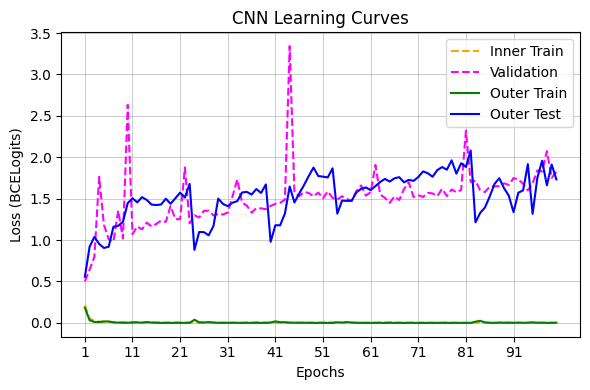

In [15]:
############################# REAL DATA, CNN Efficient-NetB0 ################################
date_str = "20250926"  # if want this cell to override the date set at top
model_name = "CNN"

# Load losses (for plot_learning curves())
save_dir_l = os.path.join("saved_performances", model_name, "losses", date_str)

inner_train_losses = np.load(os.path.join(save_dir_l, f"inner_train_losses_{dataset_name}.npy"), allow_pickle=True)
val_losses = np.load(os.path.join(save_dir_l, f"val_losses_{dataset_name}.npy"), allow_pickle=True)
outer_train_losses = np.load(os.path.join(save_dir_l, f"outer_train_losses_{dataset_name}.npy"), allow_pickle=True)
test_losses = np.load(os.path.join(save_dir_l, f"test_losses_{dataset_name}.npy"), allow_pickle=True)

num_epochs = 100
epochs = np.arange(1, num_epochs+1)

# Run plot
plot_learning_curves(epochs, inner_train_losses, val_losses, outer_train_losses, test_losses, model_name=model_name, show_std=False)

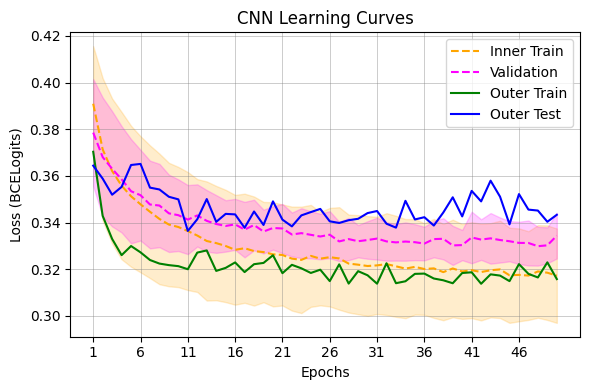

In [ ]:
################### REAL DATA, ResNet18 ###########################
date_str = "20251008"  # if want this cell to override the date set at top
model_name = "CNN"

# Load losses (for plot_learning curves())
save_dir_l = os.path.join("saved_performances", model_name, "losses", date_str)

inner_train_losses = np.load(os.path.join(save_dir_l, f"inner_train_losses_{dataset_name}.npy"), allow_pickle=True)
val_losses = np.load(os.path.join(save_dir_l, f"val_losses_{dataset_name}.npy"), allow_pickle=True)
outer_train_losses = np.load(os.path.join(save_dir_l, f"outer_train_losses_{dataset_name}.npy"), allow_pickle=True)
test_losses = np.load(os.path.join(save_dir_l, f"test_losses_{dataset_name}.npy"), allow_pickle=True)

num_epochs = config['models'][model_name]['training']['epochs']
epochs = np.arange(1, num_epochs+1)

# Run plot
plot_learning_curves(epochs, inner_train_losses, val_losses, outer_train_losses, test_losses, model_name=model_name, show_std=True)

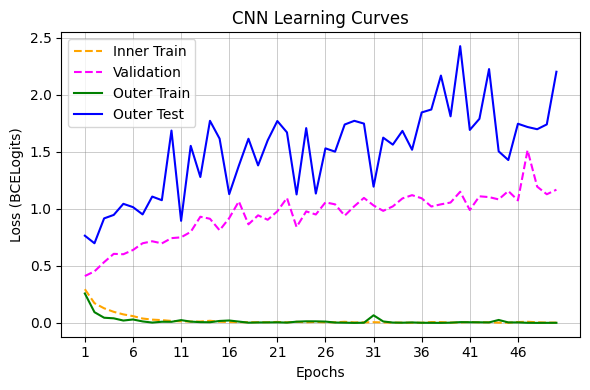

In [6]:
################### REAL DATA, ResNet18 ###########################
date_str = "20251010"
model_name = "CNN"

# Load losses (for plot_learning curves())
save_dir_l = os.path.join("saved_performances", model_name, "losses", date_str)

inner_train_losses = np.load(os.path.join(save_dir_l, f"inner_train_losses_{dataset_name}.npy"), allow_pickle=True)
val_losses = np.load(os.path.join(save_dir_l, f"val_losses_{dataset_name}.npy"), allow_pickle=True)
outer_train_losses = np.load(os.path.join(save_dir_l, f"outer_train_losses_{dataset_name}.npy"), allow_pickle=True)
test_losses = np.load(os.path.join(save_dir_l, f"test_losses_{dataset_name}.npy"), allow_pickle=True)

num_epochs = config['models'][model_name]['training']['epochs']
epochs = np.arange(1, num_epochs+1)

# Run plot
plot_learning_curves(epochs, inner_train_losses, val_losses, outer_train_losses, test_losses, model_name=model_name)

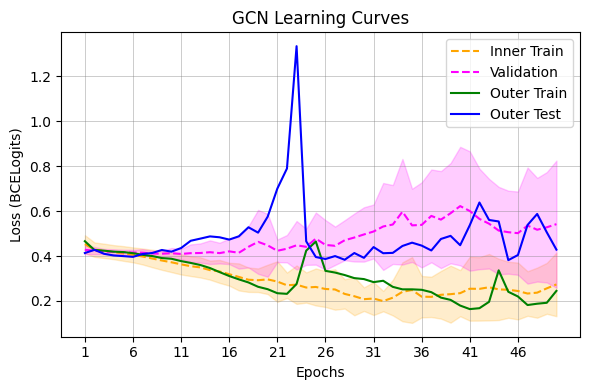

In [8]:
################### REAL DATA, NODE-LEVEL GCN ###########################
date_str = "20251026"
model_name = "GCN"

# Load losses (for plot_learning curves())
save_dir_l = os.path.join("saved_performances", model_name, "losses", date_str)

inner_train_losses = np.load(os.path.join(save_dir_l, f"inner_train_losses_{dataset_name}.npy"), allow_pickle=True)
val_losses = np.load(os.path.join(save_dir_l, f"val_losses_{dataset_name}.npy"), allow_pickle=True)
outer_train_losses = np.load(os.path.join(save_dir_l, f"outer_train_losses_{dataset_name}.npy"), allow_pickle=True)
test_losses = np.load(os.path.join(save_dir_l, f"test_losses_{dataset_name}.npy"), allow_pickle=True)

num_epochs = config['models'][model_name]['training']['epochs']
epochs = np.arange(1, num_epochs+1)

# Run plot
plot_learning_curves(epochs, inner_train_losses, val_losses, outer_train_losses, test_losses, model_name=model_name, show_std=True)

In [38]:
############################# REAL DATA ################################

# Load metrics (for plot_performance_[bar/box/heatmap]()) for ALL DATASETS
save_dir_CNN = os.path.join("saved_performances", "CNN", "metrics", date_str)
save_dir_GCN = os.path.join("saved_performances","GCN", "metrics", date_str)

num_outer_folds = 5
task_paradigms = ["Axcpt", "Cuedts", "Stern", "Stroop"]
methods = ["Sliding Window", "Time-Frequency", "CAP", "Multichannel"]
models = ["CNN", "GCN"]

scores_dict = {
    "Task_Paradigm": [],
    "Assessment_Method": [],
    "Model": [],
    "Score": []
}

metric_map = {"Balanced Accuracy": "acc", "AUC": "auc"}
metric_n = metric_map[metric_name]  # acc or auc

method_map = {
    "Sliding Window": "sw",
    "Time-Frequency": "tf",
    "CAP": "cap",
    "Multichannel": "multichannel-sw-tf-cap"
}


for model in models:
    for method in methods:
        for task in task_paradigms:
            if method == "Multichannel" and model == "GCN":
                scores = np.full(num_outer_folds, np.nan)
            else:
                method_file = method_map[method]
                filename = f"{metric_n}_{task.lower()}_{method_file}.npy"
                if model == "CNN":
                    filepath = os.path.join(save_dir_CNN, filename)
                else:
                    filepath = os.path.join(save_dir_GCN, filename)
                if os.path.exists(filepath):
                    scores = np.load(filepath)
                else:
                    print(f"Warning: missing {filepath}")
                    scores = np.full(num_outer_folds, np.nan)

            scores_dict["Task_Paradigm"].append(task)
            scores_dict["Assessment_Method"].append(method)
            scores_dict["Model"].append(model)
            scores_dict["Score"].append(scores)


display(make_long_df(scores_dict)[100:120])

,Task_Paradigm,Assessment_Method,Model,Score
100,Axcpt,Time-Frequency,GCN,0.5401
101,Axcpt,Time-Frequency,GCN,0.5574
102,Axcpt,Time-Frequency,GCN,0.6274
103,Axcpt,Time-Frequency,GCN,0.5377
104,Axcpt,Time-Frequency,GCN,0.5101
105,Cuedts,Time-Frequency,GCN,0.5174
106,Cuedts,Time-Frequency,GCN,0.5067
107,Cuedts,Time-Frequency,GCN,0.5609
108,Cuedts,Time-Frequency,GCN,0.5095
109,Cuedts,Time-Frequency,GCN,0.5021


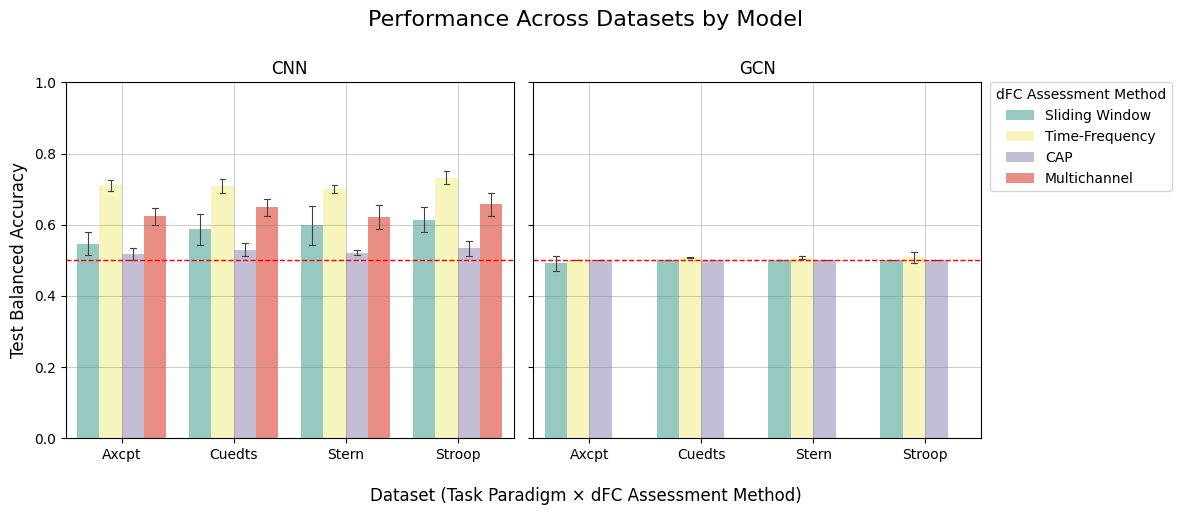

In [17]:
plot_performance_bar(scores_dict, metric_name=metric_name)

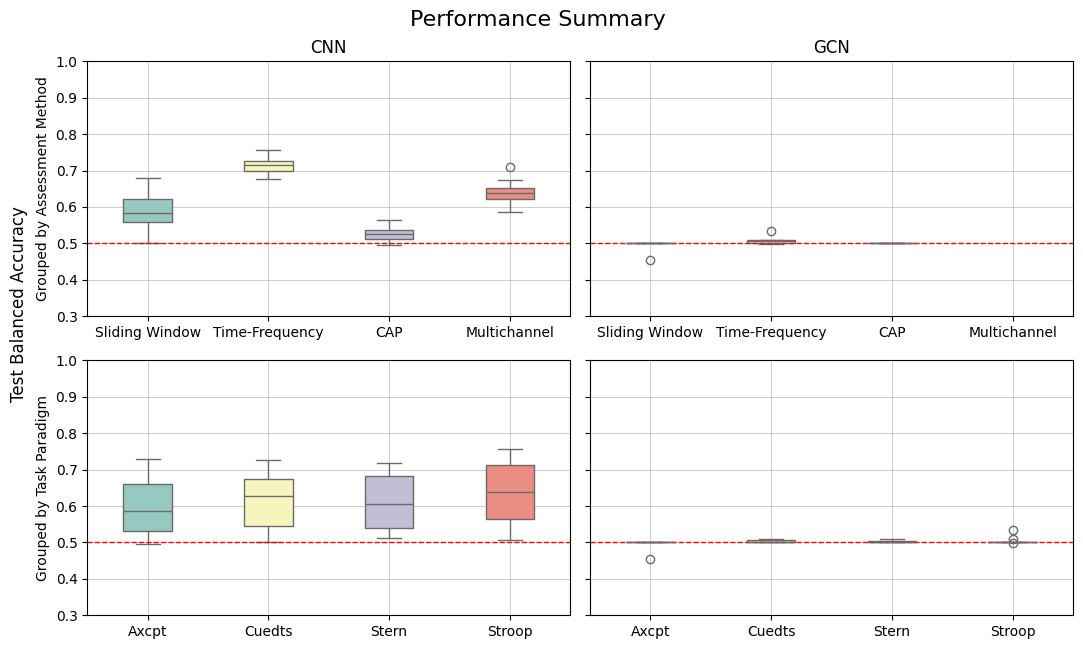

In [34]:
plot_performance_box(scores_dict, metric_name=metric_name)

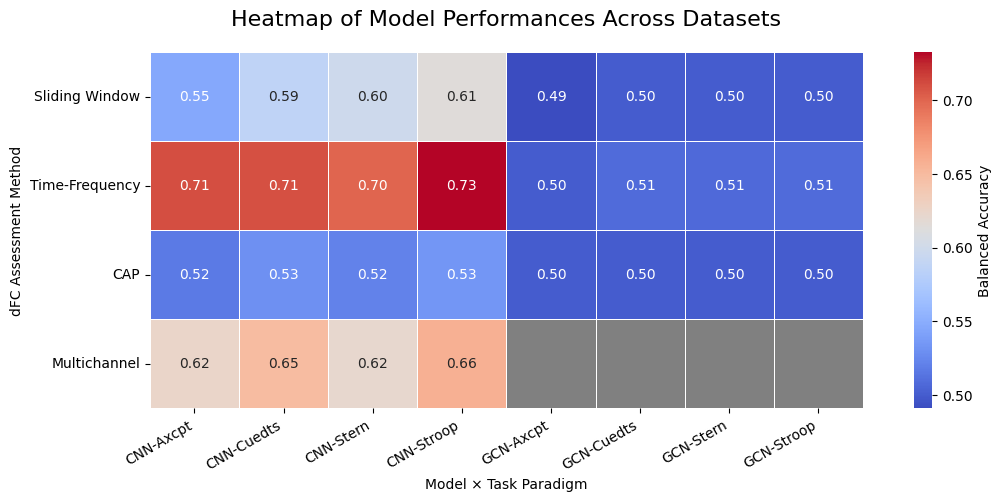

In [35]:
plot_performance_heatmap(scores_dict, metric_name=metric_name)

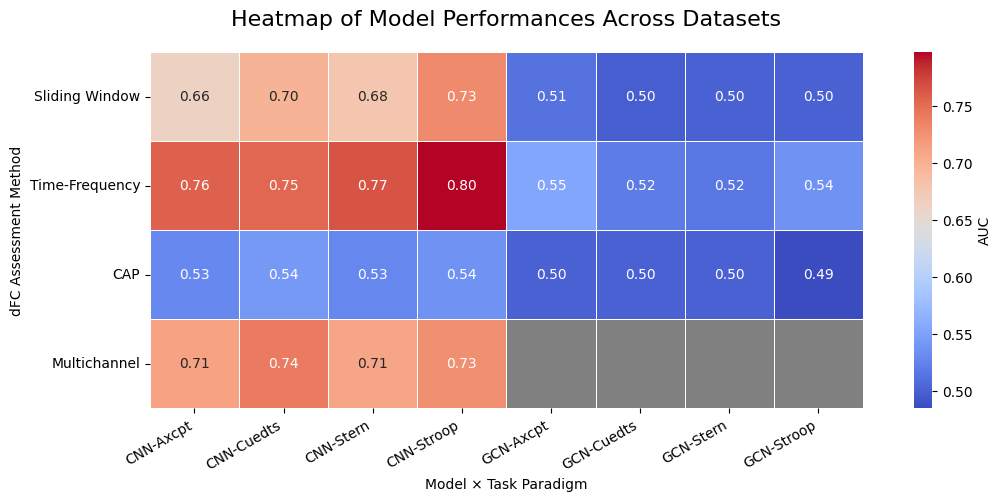

In [39]:
# AUC
plot_performance_heatmap(scores_dict, metric_name=metric_name)

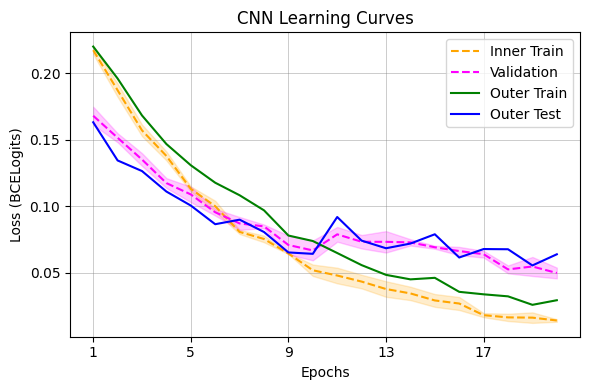

In [12]:
############# TOY Data Example 1 - Learning Curves with CNN ##############
np.random.seed(42)
overfitting_example = True

if overfitting_example: # overfitting starts ~epoch 10
    num_epochs = 20
    num_inner_folds = 3
    epochs = np.arange(1, num_epochs+1)

    # Training losses (keep decreasing smoothly)
    inner_train_losses = np.array([
        0.25 * np.exp(-epochs/6) + 0.015*np.random.rand(num_epochs)
        for _ in range(num_inner_folds)
    ])

    # Validation losses (decrease until ~10, then rise = overfitting)
    val_losses = np.array([
        0.18 * np.exp(-epochs/8) + 0.01*epochs/num_epochs + 0.02*np.random.rand(num_epochs)
        for _ in range(num_inner_folds)
    ])
    # Force plateau/uptick after epoch 10
    val_losses[:, 10:] += 0.02  

    # Outer train curve
    outer_train_curve = 0.24 * np.exp(-epochs/8) + 0.01*np.random.rand(num_epochs)

    # Test curve (similar to val, with overfitting after ~10)
    test_curve = 0.16 * np.exp(-epochs/9) + 0.012*epochs/num_epochs + 0.02*np.random.rand(num_epochs)
    test_curve[10:] += 0.02  

    # Clip everything into [0, 0.3]
    inner_train_losses = np.clip(inner_train_losses, 0, 0.3)
    val_losses = np.clip(val_losses, 0, 0.3)
    outer_train_curve = np.clip(outer_train_curve, 0, 0.3)
    test_curve = np.clip(test_curve, 0, 0.3)

    # Run plot
    plot_learning_curves(
        epochs,
        inner_train_losses,
        val_losses,
        outer_train_curve,
        test_curve,
        model_name="CNN"
    )
    
else: # no overfitting example plot
    num_epochs = 20
    num_inner_folds = 3
    epochs = np.arange(1, num_epochs+1)

    # Simulate exponential decay + noise for train/val losses
    inner_train_losses = np.array([np.exp(-epochs/4) + 0.1*np.random.rand(num_epochs) 
                                for _ in range(num_inner_folds)])
    val_losses = np.array([np.exp(-epochs/9) + 0.15*np.random.rand(num_epochs) 
                        for _ in range(num_inner_folds)])

    # Outer fold curves
    outer_train_curve = np.exp(-epochs/9) + 0.05*np.random.rand(num_epochs)
    test_curve = np.exp(-epochs/10) + 0.08*np.random.rand(num_epochs)

    # Run plot
    plot_learning_curves(epochs, inner_train_losses, val_losses, outer_train_curve, test_curve, model_name="CNN")

In [13]:
############# TOY Data Example 2 - Metric Performance Plots with CNN ##############

num_outer_folds = 5
task_paradigms = ["Axcpt", "Cuedts", "Stern", "Stroop"]
methods = ["Sliding Window", "Time-Frequency", "CAP", "Multichannel"]
models = ["CNN", "GCN"]

# Build dict with same structure as the real saved results
data_toy2 = {
    "Task_Paradigm": [],
    "Assessment_Method": [],
    "Model": [],
    "Score": []
}

for model in models:
    for method in methods:
        for task in task_paradigms:
            if method == "Multichannel" and model == "GCN":
                # invalid combo, NaNs for all folds
                scores = np.full(num_outer_folds, np.nan)
            else:
                # one array of 5 scores, one for each outer fold
                scores = np.random.rand(num_outer_folds) * 0.2 + 0.55
            data_toy2["Task_Paradigm"].append(task)
            data_toy2["Assessment_Method"].append(method)
            data_toy2["Model"].append(model)
            data_toy2["Score"].append(scores)  # array, not list-of-lists, else error
            

# To see how make_long_df() works
display(make_long_df(data_toy2))

,Task_Paradigm,Assessment_Method,Model,Score
0,Axcpt,Sliding Window,CNN,0.641152
1,Axcpt,Sliding Window,CNN,0.670158
2,Axcpt,Sliding Window,CNN,0.698172
3,Axcpt,Sliding Window,CNN,0.608449
4,Axcpt,Sliding Window,CNN,0.641476
...,...,...,...,...
155,Stroop,Multichannel,GCN,NaN
156,Stroop,Multichannel,GCN,NaN
157,Stroop,Multichannel,GCN,NaN
158,Stroop,Multichannel,GCN,NaN


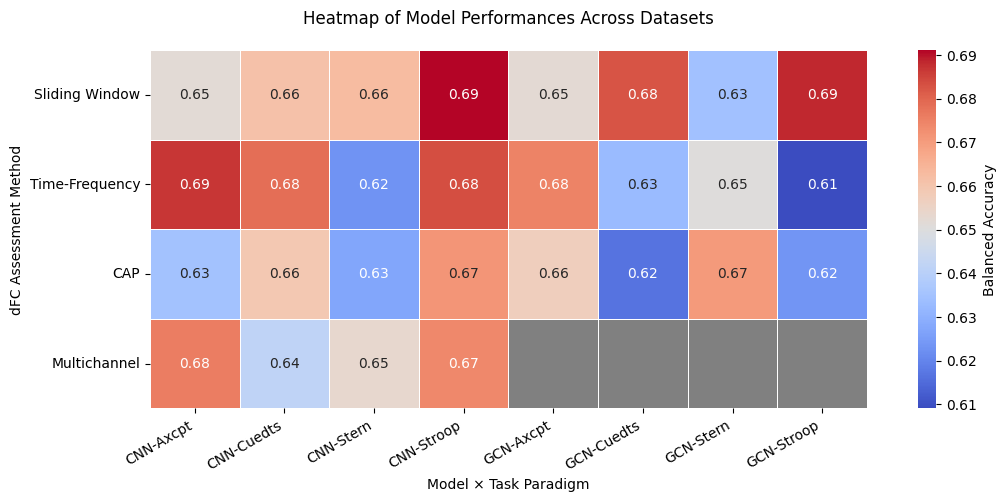

In [14]:
plot_performance_heatmap(data_toy2, metric_name="Balanced Accuracy")

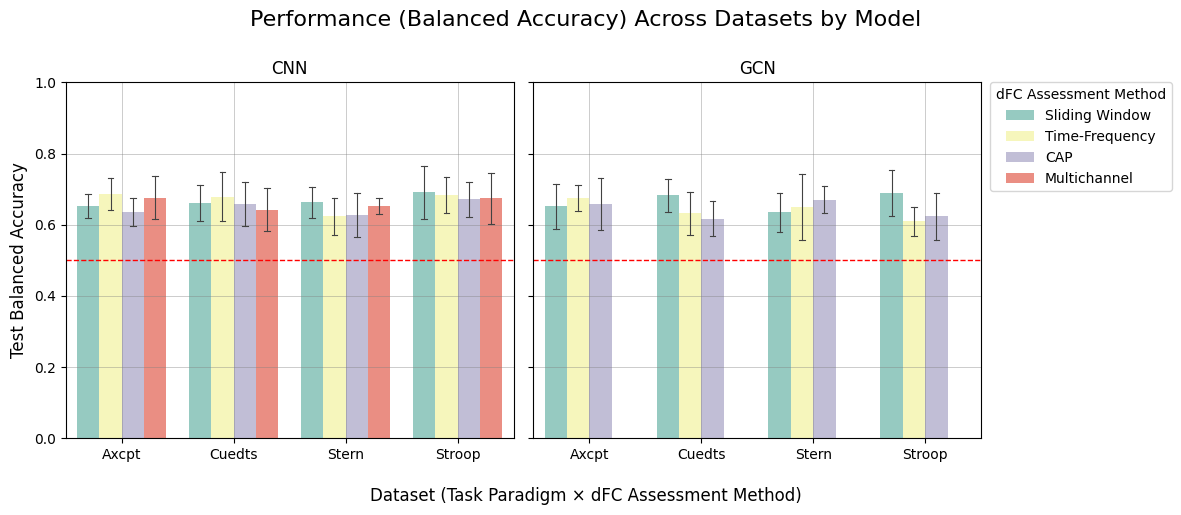

In [31]:
plot_performance_bar(data_toy2)

In [ ]:
plot_performance_box(data_toy2)